In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

from wildboar.ensemble import IsolationShapeletForest

def load_data(train_file, test_file):
    train = np.loadtxt(train_file, delimiter=",")
    test = np.loadtxt(test_file, delimiter=",")
    train = np.vstack([train, test])
    y = train[:, 0].astype(np.float64)
    y = np.ascontiguousarray(y)
    x = np.ascontiguousarray(train[:, 1:].astype(np.float64))
    return x, y
x, y = load_data("data/TwoLeadECG_TRAIN", "data/TwoLeadECG_TEST")

In [2]:
def split_train_test(x, y, normal_class, random_state, test_size = 0.2, anomalies_test_size = .95):
    normal = y == normal_class
    y = y.copy()
    y[normal] = 1
    y[~normal] = -1

    x_normal = x[np.where(y==1)]
    x_anomalous = x[np.where(y==-1)]
    y_normal = y[np.where(y==1)]
    y_anomalous = y[np.where(y==-1)]
    x_normal_train, x_normal_test, y_normal_train, y_normal_test = train_test_split(
        x_normal, y_normal, test_size=test_size, random_state=random_state
    )
    x_anomalous_train, x_anomalous_test, y_anomalous_train, y_anomalous_test = train_test_split(
        x_anomalous, y_anomalous, test_size=anomalies_test_size, random_state=random_state,
    )

    x_train = np.vstack([x_normal_train, x_anomalous_train])
    y_train = np.hstack([y_normal_train, y_anomalous_train])
    x_test = np.vstack([x_normal_test, x_anomalous_test])
    y_test = np.hstack([y_normal_test, y_anomalous_test])
    return x_train, x_test, y_train, y_test

In [3]:
random_state = check_random_state(123)
x_train, x_test, y_train, y_test = split_train_test(
    x, y, 1, random_state, test_size=0, anomalies_test_size=0.95)

In [4]:
pd.DataFrame(y_train).value_counts()

 1.0    464
-1.0     29
dtype: int64

In [5]:
pd.DataFrame(y_test).value_counts()

-1.0    552
 1.0    117
dtype: int64

In [6]:
f = IsolationShapeletForest(
    random_state=check_random_state(123),
    n_estimators=100,
    metric="euclidean",
    n_jobs=8,
    min_shapelet_size=0.2,
    max_shapelet_size=0.8)

In [7]:
f.fit(x_train)

IsolationShapeletForest(max_shapelet_size=0.8, metric='scaled_euclidean',
                        min_shapelet_size=0.2, n_jobs=8,
                        random_state=RandomState(MT19937) at 0x139A85B40)

In [8]:
y_hat = f.predict(x_test)

In [9]:
balanced_accuracy_score(y_test, y_hat)

0.5042735042735043

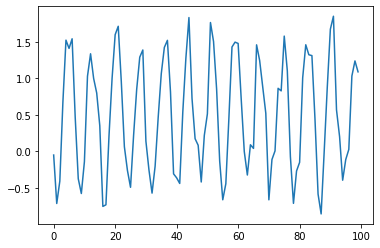

In [41]:
import matplotlib.pylab as plt
plt.plot(x[0])